# **Avance 3. Baseline**

## **Equipo #5**

**Integrantes y matriculas**

* Isaac Manriquez Calderon - A01206674
* Marcos Eduardo Garcia Ortiz - A01276213
* Jesus David Talamantes Morales - A01706335

## Introducción

**¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo?**

El problema de Watermark para textos es un problema nuevo inexplorado sin embargo se cuentan con ejemplos similares basados en audio e imagen

**Baseline posibles:**

- Regresión Lineal Múltiple 
    Aunque este problema es no lineal, podemos probar primero una regresión lineal simple que prediga el hash directamente desde las características transformadas de las firmas.
    Esto nos dará un punto de comparación para ver si un modelo más avanzado mejora significativamente la predicción.

- Árboles de Decisión o Random Forest:

    Un árbol de decisión podría servir para ver qué tan bien las características transformadas por wavelets separan los datos.
    Random Forest puede proporcionar una estimación rápida de la importancia de las características.

- K-Nearest Neighbors (KNN):

    Como baseline, podríamos entrenar un modelo KNN para ver si la transformación wavelet genera representaciones lo suficientemente diferenciadas.


**¿Se puede determinar la importancia de las características para el modelo generado?**
Recuerden que incluir características irrelevantes puede afectar negativamente el rendimiento del modelo y aumentar la complejidad sin beneficios sustanciales.

ISAAC

In [57]:
# Importar Librerias.
# Comando para recargar cambios en librerias automaticamente.
%load_ext autoreload 
%autoreload 2
import sys, os
from pathlib import Path
sys.path.append(os.path.abspath(os.path.join('..')))

# Librerias generales de matematicas
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# Librerias Locales del Repositorio.
from watermark.features import Utilities
from watermark.dataset import DataHandler

# Librerias de Machine Learning.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import pad_sequences  # Para ajustar secuencias de entrada a una longitud específica

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
# Cargamos los datos.
dh = DataHandler() # Objeto manejador de datos.
data_dict = dh.load_data(Path("../data/raw"), "emothaw_data.pkl")

2025-02-09 20:11:45.286 | INFO     | watermark.dataset:load_data:51 - Loading data from ..\data\raw\emothaw_data.pkl
2025-02-09 20:11:45.522 | SUCCESS  | watermark.dataset:load_data:56 - Data loaded successfully from ..\data\raw\emothaw_data.pkl


## Manejo de Datos

In [59]:
# Obtener los datos de interes del dataset.
x_data_in = {} # Diccionario de Puntos en X por tarea.
y_data_in = {} # Diccionario de Puntos en Y por Tarea.
p_data_in = {} # Diccionario de Presion en cada momento por tarea.
for key in data_dict.keys():
    x_data_in[key] = [serie.X for serie in data_dict[key]] 
    y_data_in[key] = [serie.Y for serie in data_dict[key]] 
    p_data_in[key] = [serie.Pressure for serie in data_dict[key]] 


In [60]:
# Generamos una copia en forma de lista de los datos en los diccionarios.
names_list = list(data_dict.keys())
list_data_x = [x_data_in[key] for key in names_list]
list_data_y = [y_data_in[key] for key in names_list]
list_data_p = [p_data_in[key] for key in names_list]
print("Número de Usuarios:", len(list_data_x))
print("Número de Tareas realizadas:", len(list_data_x[0]))
print("Número de Muestras por Tarea:", len(list_data_x[0][0]))

Número de Usuarios: 7
Número de Tareas realizadas: 129
Número de Muestras por Tarea: 1474


- A continuación queremos estandarizar la longitud de todas las tareas, por lo que es necesario cortar algunas que no cumplan con nuestro largo máximo (1500) por lo que usaremos la función "get_extended_data" para esta tarea. De igual manera utilizamos una lista de strides para mantener una proporción similar en las muestras que requieran ser recortadas.

In [61]:
strides=[600, 1500, 1300, 100, 50, 1200, 900] # Estos valores se seleccionaron para mantener una proporción similar de muestras de cada una de las tareas
limit_len = 1500  # Longitud límite de las secuencias utilizadas para el entrenamiento de las redes
# Obtenemos las secuencias extendidas de las variables X, Y y Pressure
sequences_list_x = dh.get_extended_data(list_data_x, strides, limit_len)
sequences_list_y = dh.get_extended_data(list_data_y, strides, limit_len)
sequences_list_p = dh.get_extended_data(list_data_p, strides, limit_len)


Text(0.5, 1.0, 'Secuencia de Usuario 1, Tarea 2, X')

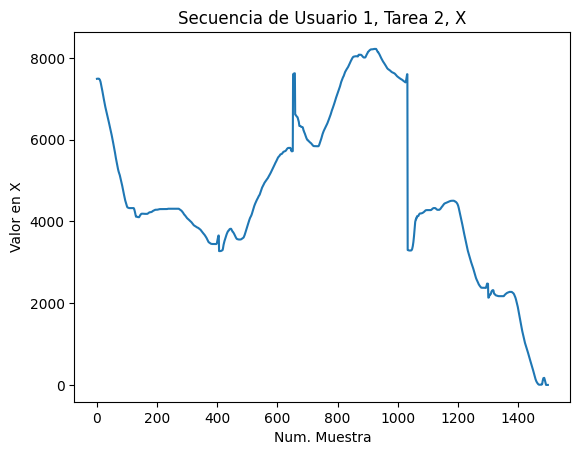

In [62]:
# Graficamos una secuencia de puntos X despues de implementar el proceso de extension.
plt.plot(sequences_list_x[0][1])
plt.xlabel("Num. Muestra")
plt.ylabel("Valor en X")
plt.title("Secuencia de Usuario 1, Tarea 2, X")   

- Aplicamos un padding (Añadir una secuencia de ceros) para estandarizar algunas señales que debido al proceso de extensión anterior no quedaron con la longitud deseada.

In [63]:
# Estandarizamos todas las señales.
x_data =[]
y_data = []
p_data = []

for i, x in enumerate(sequences_list_x): x_data.append(pad_sequences(x, maxlen=limit_len, padding='post', dtype='float64', truncating='post'))
for i, y in enumerate(sequences_list_y): y_data.append(pad_sequences(y, maxlen=limit_len, padding='post', dtype='float64', truncating='post'))
for i, p in enumerate(sequences_list_p): p_data.append(pad_sequences(p, maxlen=limit_len, padding='post', dtype='float64', truncating='post'))



In [64]:
# Combinar las secuencias de todas las tareas en un solo arreglo
# Apilar secuencias de las tareas verticalmente para cada variable.
x_tasks_data = np.vstack(x_data) 
y_tasks_data = np.vstack(y_data) 
p_tasks_data = np.vstack(p_data) 

print(f'Dimensiones finales para X: {x_tasks_data.shape}')
print(f'Dimensiones finales para Y: {y_tasks_data.shape}')
print(f'Dimensiones finales para Pressure: {p_tasks_data.shape}')

Dimensiones finales para X: (2177, 1500)
Dimensiones finales para Y: (2177, 1500)
Dimensiones finales para Pressure: (2177, 1500)


## Generación de Watermarks

In [65]:
# Generamos un objeto de utilities para las funciones.
util = Utilities()

In [66]:
# Sacamos las caracterisitcas "Wavelet" para cada una de las tareas agrupadas 
signs_x_wavelet = np.array([util.sign2wavelet(firma) for firma in x_tasks_data])
signs_y_wavelet = np.array([util.sign2wavelet(firma) for firma in y_tasks_data])

In [67]:
# Concatenar características X e Y
firmas_wavelet = np.hstack([signs_x_wavelet, signs_y_wavelet])
num_firmas = firmas_wavelet.shape[0]
print("Forma de las características extraídas:", firmas_wavelet.shape)

Forma de las características extraídas: (2177, 36)


### Generación de timestamps diferentes para marcar los trazos de cada tarea 

In [69]:
# Generamos 100 fechas diferentes utilizando una funcion.
dates_list = util.dates_generator(2)
#print("Fecha de Prueba: ", dates_list[50])
# Mandamos llamar una funcion para generar un diccionario de hashes para cada fecha
dates_hashes = {date:util.hashear_fecha(date) for date in dates_list} 
fechas_lista = list(dates_hashes.items())

dates_hashes

{'2025/01/30 01:25:28': array([172,  74, 140,  80, 124,  65, 250, 236, 129,  43, 191, 242,  72,
         56,  40, 140, 171, 224,  61, 155, 172, 141,  95, 246, 195,  15,
        203, 169, 126, 212, 172, 167]),
 '2019/04/27 01:29:54': array([ 97,   0, 243,  61, 188, 209, 215,  70, 245, 205, 164, 222, 241,
         87, 114,  69,   5,  15,  93, 227, 106,   8, 141, 206, 223, 204,
        196, 228,  49, 207, 145, 253])}

In [70]:
# Generamos una lista de aleatoria utilizando las fechas creadas.
fechas_asignadas = random.choices(fechas_lista, k=num_firmas)
hashes_entrenamiento = np.array([hash for _, hash in fechas_asignadas])
print("Forma de los hashes de entrenamiento:", hashes_entrenamiento.shape)  # Debe ser (2177, 32)

Forma de los hashes de entrenamiento: (2177, 32)


In [87]:
hashes_entrenamiento[0:10]

watermark= np.concatenate((firmas_wavelet, hashes_entrenamiento), axis=1)

watermark.shape


(2177, 68)

##  Prototipo Inicial de Red Neuronal Generadora. (Encoder)

### Definición de conjuntos de entrenamiento

In [ ]:
from sklearn.model_selection import train_test_split

# División en Train (70%) y Test+Valid (30%)
firmas_train, firmas_temp, hashes_train, hashes_temp = train_test_split(
    firmas_wavelet, hashes_entrenamiento, test_size=0.3, random_state=42
)

# División en Validación (15%) y Prueba (15%)
firmas_val, firmas_test, hashes_val, hashes_test = train_test_split(
    firmas_temp, hashes_temp, test_size=0.5, random_state=42
)

# Verificar tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento:", firmas_train.shape)
print("Tamaño del conjunto de validación:", firmas_val.shape)
print("Tamaño del conjunto de prueba:", firmas_test.shape)


Tamaño del conjunto de entrenamiento: (1523, 36)
Tamaño del conjunto de validación: (327, 36)
Tamaño del conjunto de prueba: (327, 36)


## Red Neuronal Generadora

In [49]:
input_dim = firmas_train.shape[1]  # Número de características extraídas
hash_dim = hashes_train.shape[1]  # 32 valores del hash

inputs = keras.Input(shape=(input_dim,))

# Capa 1
x = layers.Dense(512, activation="relu")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Capa 2
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Capa 3
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Capa 4
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Capa de salida
encoded = layers.Dense(hash_dim, activation="sigmoid")(x)  # 32 valores para hash

# Crear el modelo
modelo_generador = keras.Model(inputs, encoded)
modelo_generador.compile(optimizer="adam", loss="mse")

# Entrenar la red con validación
history = modelo_generador.fit(
    firmas_train, hashes_train,
    validation_data=(firmas_val, hashes_val),  # Evaluamos en validación en cada epoch
    epochs=200,
    batch_size=8,
    verbose=1
)

Epoch 1/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 21322.0273 - val_loss: 21385.9707
Epoch 2/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21354.3145 - val_loss: 21343.6016
Epoch 3/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 21275.8848 - val_loss: 21321.6367
Epoch 4/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21225.5938 - val_loss: 21319.5508
Epoch 5/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21355.3457 - val_loss: 21319.4316
Epoch 6/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 21341.2461 - val_loss: 21319.3906
Epoch 7/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 21201.9590 - val_loss: 21319.2988
Epoch 8/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 21240.4082 - val_loss: 21319.2969
Epoch 9/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 21241.4805 - val_loss: 21319.3359
Epoch 10/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 21284.4805 - val_loss: 21319.1992
Epoch 11/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

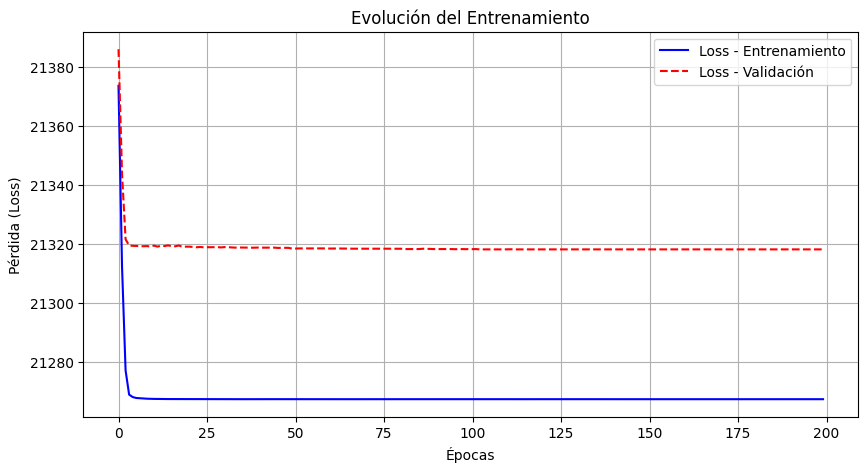

In [ ]:
def plot_training_history(history):
    """
    Genera una gráfica de la evolución del entrenamiento de la red neuronal.

    """
    plt.figure(figsize=(10, 5))
    
    # Gráfica de la pérdida (loss)
    plt.plot(history.history['loss'], label='Loss - Entrenamiento', color='blue')
    plt.plot(history.history['val_loss'], label='Loss - Validación', color='red', linestyle='dashed')

    # Configuración del gráfico
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida (Loss)')
    plt.title('Evolución del Entrenamiento')
    plt.legend()
    plt.grid(True)
    
    # Mostrar la gráfica
    plt.show()

# Suponiendo que la variable `history` contiene el historial de entrenamiento de Keras:
plot_training_history(history)

**¿El modelo está sub/sobreajustando los datos de entrenamiento?**

Actualmente el modelo con un primer entrenamiento y definición de la red neuronal observamos que la red esta sub entrenando, de esta información dada la perdida tan elevada nos lleva a considerar analizar de manera más detallada la manera en como estamos tratando de resolver el problema, en base a la investigación previa realizada para este reto sabemos que la solución al problema se basa en redes neuronales, sin embargo durante esta fase notamos la importancia de estar abiertos a otros enfoques.

Para poder aplicar la técnica de Zero-Watermarking se requerirá un procesamiento diferente de los datos para generar una marca única la cual no afecta el patron original y se ocupa como llave del patron de encriptación, esta deducción más clara fue posible gracias a la consideración de otros casos y la corrida inicial de el modelo de red neuornal, en la que observamos que no se esta llegando a la convergencia esperada.

¿Cuál es la métrica adecuada para este problema de negocio? 

ISAAC

**¿Cuál debería ser el desempeño mínimo a obtener?**

En base al tabajo anterior realizado para sus apartados de entrenamiento en el problema se tienen estadísticas respecto al MSE Mean Square Error, consideramos que obtener valores menores a estos que actualmente rondan en el 400

Además de ello contamos con otros valores del entrenamiento que son la perdida que aunque se reduce considerablemente desde 12,000 llega unicamente a 900.

Esperamos obtener valores de precision y accuracy que superen el 85% pues respecto a investigaciones similares este es el umbral de desempeño